**기본 세팅**

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

---

# 3. 평균 이동

**평균 이동(Mean Shift)**

평균 이동(Mean Shift)는 K-Means와 유사하게 중심을 군집의 중심으로 지속적으로 움직이며 군집화한다.

두 방법의 차이점은 중심을 이동하는 방법이다.


- K-Means: 중심에 소속된 데이터의 평균 거리 중심으로 이동한다.


- 평균 이동: 중심을 데이터가 모여 있는 밀도가 가장 높은 곳으로 이동한다.

**수행과정**

1. 평균 이동은 KDE(Kernerl Density Estimation)를 이용해서 확률 밀도 함수를 구한다.


2. 데이터가 집중적으로 모여있어 확률 밀도 함수가 피크인 점을 군집 중심점으로 선정한다.


3. 이러한 방식을 전체 데이터에 반복적으로 적용하면서 데이터의 군집 중심점을 찾는다.

**KDE**

KDE는 커널 함수를 통해 어떤 변수의 확률 밀도 함수를 추정하는 대표적인 방법이다.

개별 관측 데이터에 커널 함수를 적용한 뒤, 이 적용 값을 모두 더한 후 데이터의 건수로 나눠 확률 밀도 함수를 추정한다.

KDE는 다음과 같은 커널 함수식으로 표현된다.

$$\text{KDE} = \dfrac{1}{n} \sum_{i}^{n} K_{n}(x-x_{i}) = \dfrac{1}{nh} \sum_{i}^{n} K\dfrac{(x-x_{i})}{h}$$

- $K$: 커널 함수


- $x$: 확률 변수값


- $x_{i}$: 관측값


- $h$: 대역폭(bandwidth)

대역폭은 KDE 형태를 결정하는 요소로 어떻게 설정하느냐에 따라 확률 밀도 추정 성능을 좌우한다.

대역폭이 작을수록 좁고 뾰족한 KDE를 가지며 이는 변동성이 큰 방식으로 확률 밀도 함수를 추정해 과적합하기 쉽다.

반대로 값이 클수록 넓고 완만한 KDE로 지나치게 단순화 되어 과소적합하기 쉽다.

일반적으로 평균 이동 군집화는 대역폭이 클수록 적은 군집 중심점을 가지고, 작을수록 많은 군집 중심점을 가진다.

평균 이동 군집화는 K-Means와 달리 군집의 개수를 지정하지 않고 대역폭에 따라 군집화를 수행한다.

**장단점**

- 데이터를 특정 형태로 가정하거나, 특정 분포 기반 모델로 가정하지 않으므로 유연한 군집화가 가능하다.


- 이상치의 영향력이 크지 않으며 군집의 개수를 정할 필요도 없다.


- 알고리즘 수행 시간이 오래 걸리고 대역폭(bandwidth)의 크기에 따른 군집화 영향이 매우 크다.

## 3.1 가상데이터 평균 이동

In [3]:
from sklearn.datasets import make_blobs
from sklearn.cluster import MeanShift

# 클러스터 3개인 가상데이터
X, y = make_blobs(n_samples=200, n_features=2, centers=3, cluster_std=0.7, random_state=0)

# Mean Shift
meanshift = MeanShift(bandwidth=0.8)
cluster_labels = meanshift.fit_predict(X)

print(f"Mean Shift Cluster 유형: {np.unique(cluster_labels)}")

Mean Shift Cluster 유형: [0 1 2 3 4 5]


- 군집이 3개인 데이터로 평균 이동을 했는데 군집이 6개로 지나치게 세분화되어 군집화되었다.

In [4]:
# Mean Shift
meanshift = MeanShift(bandwidth=1)
cluster_labels = meanshift.fit_predict(X)

print(f"Mean Shift Cluster 유형: {np.unique(cluster_labels)}")

Mean Shift Cluster 유형: [0 1 2]


- 대역폭(bandwith)를 조금 더 증가 시킨 후 평균 이동을 하였다.


- 3개의 군집으로 잘 군집화 되었다.


- 대역폭에 따라 군집의 개수는 큰 영향을 받으므로 최적의 대역폭을 찾는 것이 중요하다.

In [5]:
from sklearn.cluster import estimate_bandwidth

bandwidth = estimate_bandwidth(X)
print('bandwidth 값:', round(bandwidth,3))

bandwidth 값: 1.816


- `estimate_bandwidth()`는 최적화된 대역폭 값을 반환해준다.


- 여기서 구한 최적 대역폭으로 다시 평균 이동을 해보자.

In [6]:
# 최적 bandwidth
best_bandwidth = estimate_bandwidth(X)

meanshift = MeanShift(bandwidth = best_bandwidth)
cluster_labels = meanshift.fit_predict(X)
print('best bandwidth cluster labels 유형:',np.unique(cluster_labels))

best bandwidth cluster labels 유형: [0 1 2]


- 최적의 대역폭으로 평균 이동시 3개의 군집으로 잘 군집화 되었다.


- 이를 시각화해서 살펴보자.

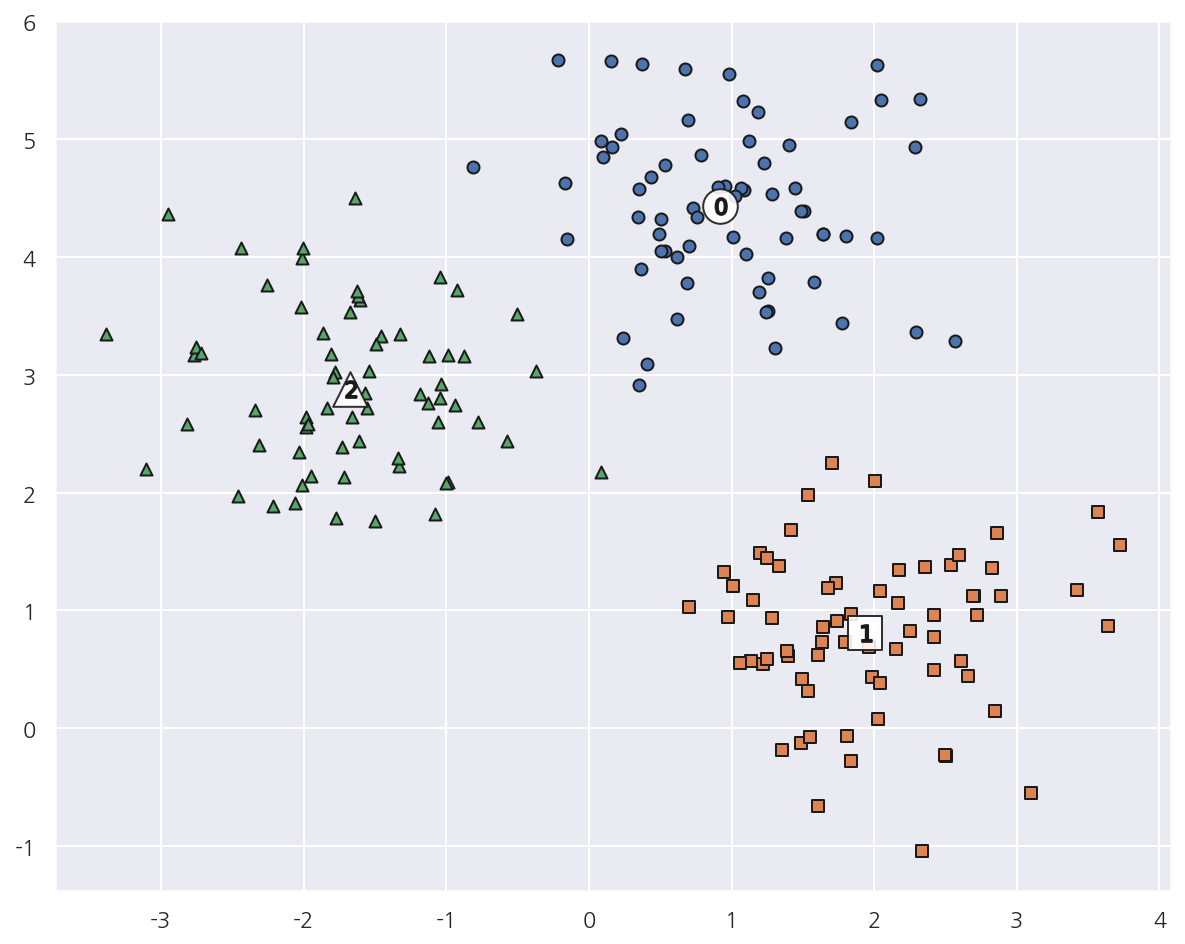

In [7]:
# 데이터 프레임 생성
cluster_df = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
cluster_df['target'] = y
cluster_df["meanshift_label"] = cluster_labels

# 클러스터별 중심 위치 좌표
centers = meanshift.cluster_centers_

# cluster 값 종류
unique_labels = np.unique(cluster_labels)

markers=['o', 's', '^', 'P','D','H','x']

for cluster in unique_labels:
    
    # 각 군집 시각화
    cluster_v = cluster_df[cluster_df['meanshift_label'] == cluster]    
    plt.scatter(x=cluster_v['ftr1'], y=cluster_v['ftr2'], edgecolor='k', marker=markers[cluster] )
    
    # 군집별 중심 위치 시각화
    center_xy = centers[cluster]
    
    plt.scatter(x = center_xy[0], y = center_xy[1], s=300, color='white',
                alpha=0.9, edgecolor='k', marker = markers[cluster])
    
    plt.scatter(x = center_xy[0], y = center_xy[1], s=70, color='k', 
                edgecolor='k', marker = f"${cluster}$")
    
    
plt.show()

- 평균 이동 역시 K-Means처럼 중심을 가지고 있으므로 `cluster_centers_` 속성을 사용 가능하다.

In [8]:
cluster_df.groupby(['target','meanshift_label']).size()

target  meanshift_label
0       0                  67
1       1                  67
2       2                  66
dtype: int64

- target과 평균 이동으로 생성된 군집이 완벽하게 매칭됨을 확인 할 수 있다.